In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [21]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000
LR = 5e-5
NUM_EPOCHS = 12

# Task VIII: Quantum Vision transformer

Problem Statement: Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

## Methodology for Addressing the Problem



### Dataset

We will be using the MNIST dataset for this task which contains a training set of 60,000 images and a test set of 10,000 images of handwritten digits. The handwritten digit images have been size-normalized and centered in a fixed size of 28×28 pixels. The dataset is commonly used for training various image processing systems.

### Classical Vision Transformer Architecture

The quantum discriminator (qdisc) consists of 8 qubits. The first 5 qubits are the data qubits, where the quantum data circuit will be connected to qdisc. The last 3 qubits are the output qubits, where the first two outputs are considered as the class prediction [$C_{0}$, $C_{1}$] ([1, -1] for label 0 and [-1, 1] for label 1) and the last output is considered as the real/fake prediction [$D$] (1 for real and -1 for fake).

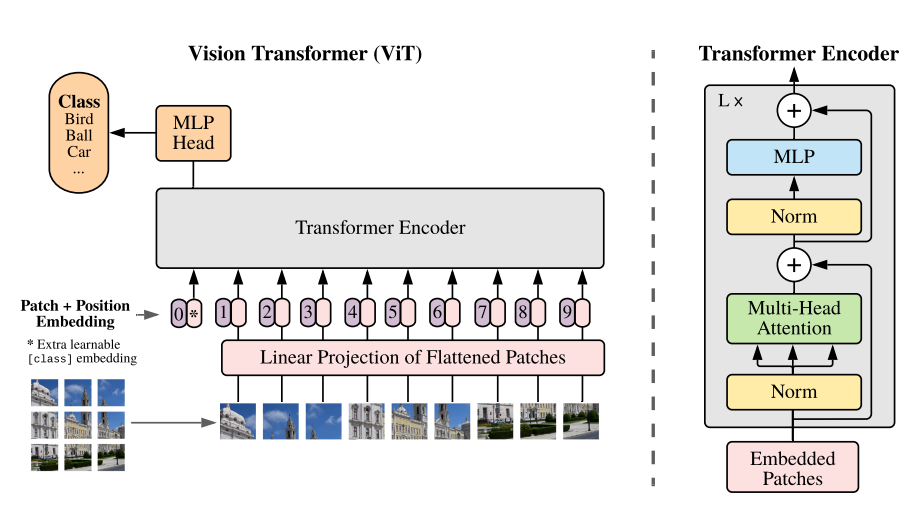

**Figure 1**: Classical Vision Transformer Overivew.

As shown in Fig-1 it employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. The ViT model architecture is almost the same as the original Transformer but with a twist to allow images to be treated as input.

## Code Implementation

### Preprocessing

In [6]:
mean, std = (0.1307,), (0.3081,)

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(mean, std)])

In [ ]:
train_set = torchvision.datasets.MNIST('../data/MNIST/', train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST('../data/MNIST/', train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

### ViT Model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [10]:
# Please change the current directory to the correct directory of the .py file if you want to run this code
from transformer_package.models import ViT

 Vision Transformer model with a patch size of 7x7 (which for a 28x28 image would mean 4 x 4 = 16 patches per image), 10 possible target classes (0 to 9), and 1 color channel (since the images are grayscale).

In terms of the network parameters, we use an embedding dimension of 512 units, a depth of 3 Transformer blocks, 8 transformer heads, and 256 units in the hidden layer of the output MLP head. 

In [11]:
image_size = 28
channel_size = 1
patch_size = 7
embed_size = 512
num_heads = 8
classes = 10
num_layers = 3
hidden_size = 256
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): VisionEncoder

### Training

In [12]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [16]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

The above function loops over every batch in the data_loader object. For each batch, it calculates the output of the model (as a log_softmax) and the negative log-likelihood loss for this output, then calculates the gradients of this loss in regards to each trainable model parameter via loss.backward() and updates the parameters via optimizer.step(). Every 100th batch it provides a printed update on the progress of the training and appends the value of the current loss to the loss_history list.

In [17]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

Here we do not calculate any gradients and instead just compare the output of the model to the ground truth labels to calculate accuracy and update the loss history.

In [ ]:
train_loss_history, test_loss_history = [], []
for epoch in range(1, NUM_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

Epoch: 1
[    0/60000 (  0%)]  Loss: 1.2173
[10000/60000 ( 17%)]  Loss: 0.5812
[20000/60000 ( 33%)]  Loss: 0.2582
[30000/60000 ( 50%)]  Loss: 0.2392
[40000/60000 ( 67%)]  Loss: 0.4943
[50000/60000 ( 83%)]  Loss: 0.3241

Average test loss: 0.1700  Accuracy: 9458/10000 (94.58%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.2629
[10000/60000 ( 17%)]  Loss: 0.2211
[20000/60000 ( 33%)]  Loss: 0.1713
[30000/60000 ( 50%)]  Loss: 0.2021
[40000/60000 ( 67%)]  Loss: 0.1402
[50000/60000 ( 83%)]  Loss: 0.1847

Average test loss: 0.1202  Accuracy: 9618/10000 (96.18%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.2621
[10000/60000 ( 17%)]  Loss: 0.2664
[20000/60000 ( 33%)]  Loss: 0.1622
[30000/60000 ( 50%)]  Loss: 0.2128
[40000/60000 ( 67%)]  Loss: 0.2055
[50000/60000 ( 83%)]  Loss: 0.1224

Average test loss: 0.1005  Accuracy: 9668/10000 (96.68%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0969
[10000/60000 ( 17%)]  Loss: 0.0902
[20000/60000 ( 33%)]  Loss: 0.1551
[30000/60000 ( 50%)]  Loss: 0.1568
[40000/60000 ( 67

Test accuracy after 12 epochs: 98.40%

## Potential ideas to extend Classical Vision Transformer architecture to a Quantum Vision Transformer.




In the paper[1] a new Quantum Vision Transformer is proposed, we'll discuss it's architecture and also talk about some potential improvements in it based on recent research. Compound Transformer is a natively quantum approach to performing the attention mechanism used in the classical Vision Transformer architecture. Unlike ViT, which loads each patch independently, the Compound Transformer loads all patches in superposition and applies an orthogonal matrix with trainable weights to perform attention on each patch in superposition. The mathematical formalism behind the Compound Transformer is the second-order compound matrix, which considers both the input vector and the trainable weight matrix.

The Compound Transformer circuit has two registers: the top one of size n and the bottom one of size d. The input matrix X ∈ R^n×d is loaded into the circuit using the matrix data loader, and a quantum orthogonal layer V is applied on both registers simultaneously. The resulting state is |Y⟩ = |V(2)X⟩, where V(2) is the 2nd-order compound matrix of V. Tomography is performed on |Y⟩ to conclude that the circuit produces transformed patches (y1, · · · , yn) ∈ R^n×d.

The Compound Transformer combines the Orthogonal Patch-wise Network and the Quantum Transformer layer with one combined operation, which makes it different from the classical transformers. However, it retains some interesting properties with its classical counterpart, such as weighting patches in their global context and sharing gradients through the determinants used to generate the compound matrix. The Orthogonal Patch-wise Network[2] is a modification of the original Patch-wise Network that uses an orthogonal matrix to learn the attention coefficients between patches and the Quantum Transformer layer is a component that uses parameterized quantum circuits to learn the attention coefficients between patches in a more expressive and scalable way.

Overall, the Compound Transformer is a promising approach to extending the classical ViT architecture to a natively quantum setting. It uses quantum tools such as superposition and orthogonal matrices with trainable weights to perform attention on patches in a more efficient and parallel manner which can potentially lead to faster and more accurate image classification.

One possible way to improve the Compound Transformer architecture by replacing the Quantum Orthogonal Layer with a QAOA-based layer[3]. The QAOA (Quantum Approximate Optimization Algorithm) is a variational quantum algorithm that can be used to solve combinatorial optimization problems. It has been shown that QAOA can be used to design efficient quantum circuits for linear transformations, including orthogonal matrices. This would involve training the QAOA parameters along with the weights of the Compound Transformer. The QAOA-based layer would perform a similar function as the Quantum Orthogonal Layer, but with potentially fewer gates and less circuit depth, leading to faster computation and fewer errors.


## References

1. [Cherrat, E. A., Kerenidis, I., Mathur, N., Landman, J., Strahm, M., Li, Y. Y., Nakaji, K., & Yamamoto, N., “Quantum Vision Transformers,” Sep. 2022.](https://arxiv.org/abs/2209.08167)
2. [Gong, C., Wang. D., Li, M., Chandra, V., Qiang Liu, Q., “Vision Transformers with Patch Diversification,” Jun. 2021.](https://arxiv.org/pdf/2104.12753.pdf)
2. [Farhi, E., Goldstone, J., GutmannGong, S., “A Quantum Approximate Optimization Algorithm,” Nov. 2014.](https://arxiv.org/pdf/2104.12753.pdf)